<a href="https://colab.research.google.com/github/golesuman/66-daysofdatachallenge/blob/main/Day51/IntelImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=(256,256), scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d puneet6060/intel-image-classification

mkdir: cannot create directory ‘/root/.kaggle’: File exists
intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [ ]:

train_path='/content/seg_train/seg_train'
valid_path='/content/seg_test/seg_test'
batch_size=32
num_classes=len(os.listdir(train_path))
print(num_classes)

6


In [ ]:
data = {
    'train': datasets.ImageFolder(root=train_path, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_path, transform=image_transforms['valid'])
}
idx_to_class={v:k for k,v in data['train'].class_to_idx.items()}
print(idx_to_class)
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
print(train_data_size,valid_data_size)

{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
14034 3000


In [ ]:
train_data_loader = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=batch_size, shuffle=True)

In [ ]:

alexnet = models.alexnet(pretrained=True)
for param in alexnet.parameters():
    param.requires_grad = False
alexnet.classifier[6] = nn.Linear(4096, 6)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
loss_func = nn.NLLLoss()
optimizer = optim.Adam(alexnet.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [ ]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 5
trained_model, history = train_and_validate(alexnet.to(device), loss_func, optimizer, num_epochs)

Epoch: 1/5


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch : 001, Training: Loss: 0.3800, Accuracy: 86.6752%, 
		Validation : Loss : 0.2897, Accuracy: 89.9333%, Time: 548.5408s
Epoch: 2/5
Epoch : 002, Training: Loss: 0.3185, Accuracy: 88.6989%, 
		Validation : Loss : 0.2610, Accuracy: 91.0667%, Time: 553.9244s
Epoch: 3/5
Epoch : 003, Training: Loss: 0.3057, Accuracy: 89.5611%, 
		Validation : Loss : 0.2770, Accuracy: 90.7333%, Time: 553.0117s
Epoch: 4/5
Epoch : 004, Training: Loss: 0.2978, Accuracy: 89.3829%, 
		Validation : Loss : 0.2796, Accuracy: 90.7333%, Time: 554.9209s
Epoch: 5/5
Epoch : 005, Training: Loss: 0.2845, Accuracy: 89.8461%, 
		Validation : Loss : 0.2864, Accuracy: 90.3667%, Time: 554.1182s


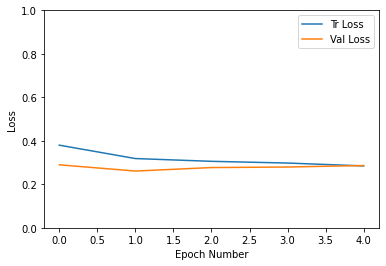

In [ ]:

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

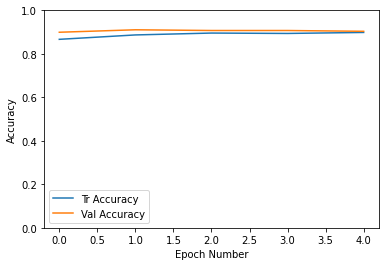

In [ ]:

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [ ]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(6, dim=1)
        topk=torch.Tensor.cpu(topk)
        topclass=torch.Tensor.cpu(topclass)
        for i in range(6):
            print("Predcition", i+1, ":", idx_to_class[topclass.numpy()[0][i]], ", Score: ", topk.numpy()[0][i])

Predcition 1 : street , Score:  0.9111726
Predcition 2 : buildings , Score:  0.088821046
Predcition 3 : sea , Score:  4.2205806e-06
Predcition 4 : glacier , Score:  1.2217763e-06
Predcition 5 : mountain , Score:  8.5155074e-07
Predcition 6 : forest , Score:  2.8500223e-08


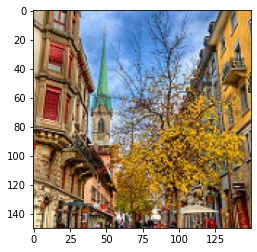

In [ ]:

predict(trained_model,'/content/seg_pred/seg_pred/10004.jpg')

Predcition 1 : forest , Score:  1.0
Predcition 2 : glacier , Score:  5.470722e-09
Predcition 3 : buildings , Score:  1.5196247e-10
Predcition 4 : street , Score:  1.4655707e-10
Predcition 5 : sea , Score:  1.5963049e-11
Predcition 6 : mountain , Score:  1.7161565e-14


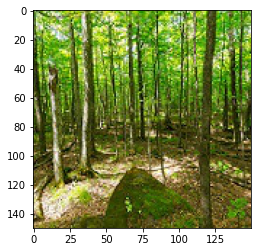

In [ ]:
predict(trained_model,'/content/seg_pred/seg_pred/10059.jpg')

Predcition 1 : forest , Score:  0.99998534
Predcition 2 : glacier , Score:  1.44637415e-05
Predcition 3 : sea , Score:  1.3468608e-07
Predcition 4 : street , Score:  1.0721318e-07
Predcition 5 : buildings , Score:  2.4167857e-08
Predcition 6 : mountain , Score:  1.9383227e-08


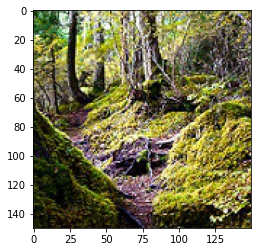

In [ ]:
predict(trained_model,'/content/seg_pred/seg_pred/10021.jpg')